# Q1: Scalar Computation Graph and Gradient

## TODO

In [0]:
import numpy as np
import matplotlib.pyplot as matplot

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def g_w1(x1: float, x2: float, w1: float, w2: float) -> float:
    g = 0
    sigm = sigmoid(w1 * x1 + w2 * x2)
    g = w1 + sigm * (1 - sigm) * x1
    return g

def g_w2(x1: float, x2: float, w1: float, w2: float) -> float:
    g = 0
    sigm = sigmoid(w1 * x1 + w2 * x2)
    g = w2 + sigm * (1 - sigm) * x2
    return g

def g_x1(x1: float, x2: float, w1: float, w2: float) -> float:
    g = 0
    sigm = sigmoid(w1 * x1 + w2 * x2)
    g = sigm * (1 - sigm) * w1
    return g

def g_x2(x1: float, x2: float, w1: float, w2: float) -> float:
    g = 0
    sigm = sigmoid(w1 * x1 + w2 * x2)
    g = sigm * (1 - sigm) * w2
    return g

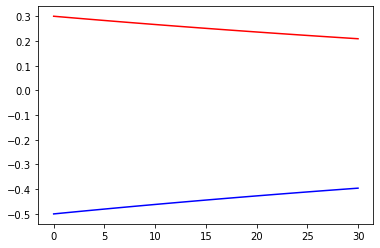

In [0]:
x1 = 0.2
x2 = 0.4
w1 = 0.3
w2 = -0.5

grads_x1 = []
grads_x2 = []
grads_w1 = []
grads_w2 = []
w1s = [w1]
w2s = [w2]

for i in range(30):
    grad_w1 = g_w1(x1, x2, w1, w2)    
    grad_w2 = g_w2(x1, x2, w1, w2)
    
    w2 += -0.01 * grad_w2
    w1 += -0.01 * grad_w1
    
    w1s.append(w1)
    w2s.append(w2)

    grads_w1.append(grad_w1)
    grads_w2.append(grad_w2)


matplot.plot(range(len(w1s)),w1s,'r',w2s,'b')


# Q3: Neural Network From Scratch

In this section, we will implement a neural network to solve MNIST, a hand-written digits (0-9) classification dataset.

## Set up

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Dict
from functools import partial

from tqdm import tqdm
tqdm.monitor_interval = 0
tqdm = partial(tqdm, bar_format='{l_bar}{r_bar}')

import torch
import torch.nn.functional as F
import torchvision

In [0]:
TRAIN_SIZE = 50_000

train = torchvision.datasets.MNIST('./data', train=True, transform=None, target_transform=None, download=True)
test = torchvision.datasets.MNIST('./data', train=False, transform=None, target_transform=None, download=True)

train_x = train.data.float().numpy()
train_y = train.targets.numpy()

shuffle_idx = np.arange(len(train_x))
np.random.RandomState(0).shuffle(shuffle_idx)
train_x = train_x[shuffle_idx]
train_y = train_y[shuffle_idx]

dev_x, dev_y = train_x[TRAIN_SIZE:], train_y[TRAIN_SIZE:]
train_x, train_y = train_x[:TRAIN_SIZE], train_y[:TRAIN_SIZE]

test_x = test.data.float().numpy()
test_y = test.targets.numpy()


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


Sample of images



label = 0


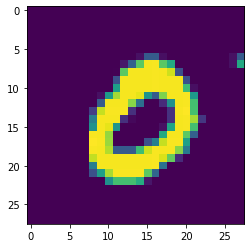

In [0]:
i = 4048 #@param {type: "slider", min: 0, max: 10000}
print(f'label = {train_y[i]}')
plt.imshow(train_x[i])
plt.show()

Each images have the same shape of 28-by-28. We flatten the matrix and pretend it is just one long vector.

In [0]:
NB_FEAT = 28 * 28

Normalize the feature. Note that we only use the training set to compute the mean and standard derivation.

In [0]:
mean = train_x.mean()
std = train_x.std()

train_x = (train_x - mean) / (std + 1e-7)
dev_x = (dev_x - mean) / (std + 1e-7)
test_x = (test_x - mean) / (std + 1e-7)

train_x = train_x.reshape(-1, NB_FEAT)
dev_x = dev_x.reshape(-1, NB_FEAT)
test_x = test_x.reshape(-1, NB_FEAT)

In [0]:
def row_logsumexp(x):
    # numerical stablization
    x_max = x.max(axis=1).reshape(-1, 1)
    return x_max + np.log(np.exp(x - x_max).sum(axis=1)).reshape(-1, 1)


In [0]:
class Parameters:
    def __init__(self):
        self.param: Dict[str, np.ndarray] = {}
        self.grad: Dict[str, np.ndarray] = {}

    def set_param(self, key: str, param: np.ndarray):
        self.param[key] = param
        self.grad[key] = np.zeros_like(param)

    def get_param(self, key):
        assert key in self.param, f'variable {key} is not part of the Parameter'
        return self.param[key]

    def accumlate_grad(self, key: str, grad: np.ndarray):
        assert key in self.param, f'variable {key} is not part of the Parameter'
        assert self.param[key].shape == grad.shape, f'for variable {key}, the shape of parameter and the shape of gradient is not matched'
        self.grad[key] += grad

    def zero_grad(self):
        for key in self.param:
            self.grad[key] = np.zeros_like(self.param[key])

    def apply_grad(self, lr: float):
        for key in self.param.keys():
            assert self.param[key].shape == self.grad[key].shape, f'for variable {key}, the shape of parameter and the shape of gradient is not matched'
            self.param[key] -= self.grad[key] * lr

In [0]:
def init_linear(input_dim, output_dim):
    return np.random.RandomState(0).randn(input_dim, output_dim) * np.sqrt(2 / input_dim)

In [0]:
def main_training(params: Parameters, forward_and_backward, train_x, train_y, dev_x, dev_y, batch_size, learning_rate, nb_epochs):
    assert isinstance(params, Parameters)
    step = 0
    best_acc = 0
    accuracy = []
    for epoch in tqdm(range(nb_epochs)):
        train_loss = []
        lr = learning_rate
        for i in range(0, len(train_x), batch_size):
            batch_x = train_x[i:i+batch_size]
            batch_y = train_y[i:i+batch_size]

            loss, probs = forward_and_backward(batch_x, batch_y, params)
            params.apply_grad(lr)

            train_loss.append(loss)
            step += 1

        accs = []
        for i in range(0, len(dev_x), batch_size):
            batch_x = dev_x[i:i+batch_size]
            batch_y = dev_y[i:i+batch_size]

            loss, probs = forward_and_backward(batch_x, batch_y, params, grad=False)
            pred_y = probs.argmax(axis=1)
            accs.extend(pred_y == batch_y)
        acc = np.mean(accs) * 100
        accuracy.append(acc)
        print(f'epoch {epoch} train loss = {np.mean(train_loss):.3f} dev accuracy = {acc:.2f}%')
        if acc > best_acc:
            best_acc = acc

    print(f'best dev accuracy = {best_acc:.2f}%')
    return accuracy

## Q2.1 Linear Classifier

Let $x \in R^{1\times N}$ be a single sample. $N$ is the number of the feature dimension and $C$ is the number of class in the final classification. Note $N=28*28$ and $C=10$

In the softmax layer, $W_{sm} \in R^{N \times C}$. The unnormalized score $s \in R^{C}$ is

$$s = x\cdot W_{sm}$$

With softmax function, we get the probability $p(c_i)$ of class $i$ where $i \in \{1,\cdots,C\}$

$$p(c_i) = \frac {\exp(s_i)} {\sum_i \exp(s_i)}$$

where $s_i$ is the $i^{th}$ element of $s$.

Assuming $y \in \{1,\cdots,C\}$, we want to minimize $-\log p(c_y)$, the cross-entropy loss between one hot true distribution `q(c_i) = 1 if i == y else 0` and $p(c_i)$.

We will take the average $-\log p(c_y)$ of a batch of x as the loss.

In `linear_classifier_forward_and_backward`, `batch_x` and `batch_y` are matrixs, where each row are $x$ and $y$, respectively.

In [0]:
linear_classifier = Parameters()
linear_classifier.set_param('w_sm', init_linear(NB_FEAT, 10))

### TODO

In [0]:
def linear_classifier_forward_and_backward(batch_x, batch_y, param: Parameters, grad=True) -> (float, np.ndarray):
    '''
    compute the loss and the gradient of each parameter
    return loss (float) and probs p(c_i) (matrix with shape batch_size x C)
    '''
    param.zero_grad()
    w_sm = param.get_param('w_sm')

    # compute loss and probs
    loss = 0
    probs = np.zeros((len(batch_x), 10))
    s = batch_x.dot(w_sm)
    b = np.max(s, axis=1).reshape(-1,1)
    s = np.exp(s - b)
    probs = s / np.sum(s, axis=1).reshape(-1,1)
    p = [each[batch_y[i]] for i, each in enumerate(probs)]
    loss = - np.mean(np.log(p))
    y = np.zeros_like(probs)
    for i, each in enumerate(y):
        new_row = each.copy()
        new_row[batch_y[i]] = 1
        y[i] = new_row
        

    if not grad:
        return loss, probs

    # compute gradient
    w_sm_grad = np.zeros_like(w_sm)
    w_sm_grad = batch_x.T.dot(probs - y) / len(batch_x)
    
    # save the gradient
    param.accumlate_grad('w_sm', w_sm_grad)
    return loss, probs

### Loss & Gradient Check

If all assertions are passed, it means you are good to go.

In [0]:
# use a prime number for batch size would make debugging easier
bs = 7
batch_x = train_x[:bs]
batch_y = train_y[:bs]
loss, probs = linear_classifier_forward_and_backward(batch_x, batch_y, linear_classifier)

w_sm = linear_classifier.get_param('w_sm')
_w_sm = torch.tensor(w_sm, dtype=torch.double, requires_grad=True)
_batch_x = torch.tensor(batch_x, dtype=torch.double, requires_grad=False)
_batch_y = torch.tensor(batch_y, dtype=torch.long, requires_grad=False)

_logits = F.linear(_batch_x, _w_sm.transpose(0,1))
_logprobs = F.log_softmax(_logits, dim=-1)
_loss = -_logprobs[torch.arange(len(_batch_y)), _batch_y].mean()
_loss.backward()
assert np.isclose(loss, _loss.item())
assert np.allclose(probs, torch.exp(_logprobs).detach().numpy())
assert np.allclose(_w_sm.grad.numpy(), linear_classifier.grad['w_sm'])

### Training

In [0]:
BS = 50
LR = 0.005
NB_EPOCH = 20

linear_classifier = Parameters()
linear_classifier.set_param('w_sm', init_linear(NB_FEAT, 10))

main_training(linear_classifier, linear_classifier_forward_and_backward, train_x, train_y, dev_x, dev_y, BS, LR, NB_EPOCH)

  5%|| 1/20 [00:01<00:23,  1.22s/it]

epoch 0 train loss = 0.619 dev accuracy = 87.97%


 10%|| 2/20 [00:02<00:21,  1.18s/it]

epoch 1 train loss = 0.380 dev accuracy = 89.59%


 15%|| 3/20 [00:03<00:19,  1.16s/it]

epoch 2 train loss = 0.347 dev accuracy = 90.25%


 20%|| 4/20 [00:04<00:17,  1.12s/it]

epoch 3 train loss = 0.330 dev accuracy = 90.87%


 25%|| 5/20 [00:05<00:16,  1.12s/it]

epoch 4 train loss = 0.318 dev accuracy = 91.14%


 30%|| 6/20 [00:06<00:15,  1.13s/it]

epoch 5 train loss = 0.310 dev accuracy = 91.33%


 35%|| 7/20 [00:07<00:14,  1.13s/it]

epoch 6 train loss = 0.304 dev accuracy = 91.48%


 40%|| 8/20 [00:08<00:13,  1.12s/it]

epoch 7 train loss = 0.299 dev accuracy = 91.57%


 45%|| 9/20 [00:10<00:12,  1.11s/it]

epoch 8 train loss = 0.295 dev accuracy = 91.60%


 50%|| 10/20 [00:11<00:11,  1.11s/it]

epoch 9 train loss = 0.292 dev accuracy = 91.68%


 55%|| 11/20 [00:12<00:09,  1.11s/it]

epoch 10 train loss = 0.289 dev accuracy = 91.79%


 60%|| 12/20 [00:13<00:08,  1.11s/it]

epoch 11 train loss = 0.286 dev accuracy = 91.80%


 65%|| 13/20 [00:14<00:07,  1.10s/it]

epoch 12 train loss = 0.284 dev accuracy = 91.78%


 70%|| 14/20 [00:15<00:06,  1.10s/it]

epoch 13 train loss = 0.281 dev accuracy = 91.79%


 75%|| 15/20 [00:16<00:05,  1.10s/it]

epoch 14 train loss = 0.280 dev accuracy = 91.79%


 80%|| 16/20 [00:17<00:04,  1.09s/it]

epoch 15 train loss = 0.278 dev accuracy = 91.82%


 85%|| 17/20 [00:18<00:03,  1.11s/it]

epoch 16 train loss = 0.276 dev accuracy = 91.88%


 90%|| 18/20 [00:20<00:02,  1.12s/it]

epoch 17 train loss = 0.275 dev accuracy = 91.86%


 95%|| 19/20 [00:21<00:01,  1.14s/it]

epoch 18 train loss = 0.273 dev accuracy = 91.86%


100%|| 20/20 [00:22<00:00,  1.13s/it]

epoch 19 train loss = 0.272 dev accuracy = 91.93%
best dev accuracy = 91.93%


[87.97,
 89.59,
 90.25,
 90.86999999999999,
 91.14,
 91.33,
 91.47999999999999,
 91.57,
 91.60000000000001,
 91.67999999999999,
 91.79,
 91.8,
 91.78,
 91.79,
 91.79,
 91.82000000000001,
 91.88,
 91.86,
 91.86,
 91.93]

## Q2.1 MLP with Single Hidden Layer

Let $x \in R^{1\times N}$ be a single sample. $N$ is the number of the feature dimension and $C$ is the number of class in the final classification.

For the first layer, $W_1 \in R^{N\times \frac{N}{2}}$ and $b_1 \in R^{\frac{N}{2}}$

$$\bar{h}_1 = x\cdot W_1 + b_1$$

$$h_1 = ReLU(\bar{h}_1)$$

In the softmax layer, $W_{sm} \in R^{\frac{N}{2} \times C}$. The unnormalized score $s \in R^{C}$ is

$$s = h_1\cdot W_{sm}$$

With softmax function, we get the probability $p(c_i)$ of class $i$ where $i \in \{1,\cdots,C\}$

$$p(c_i) = \frac {\exp(s_i)} {\sum_i \exp(s_i)}$$

where $s_i$ is the $i^{th}$ element of $s$.

Assuming $y \in \{1,\cdots,C\}$, we want to minimize $-\log p(c_y)$, the cross-entropy loss between one hot true distribution `q(c_i) = 1 if i == y else 0` and $p(c_i)$.

We will take the average $-\log p(c_y)$ of a batch of x as the loss.

In `mlp_single_hidden_forward_and_backward`, `batch_x` and `batch_y` are matrixs, where each row are $x$ and $y$, respectively.

In [0]:
mlp_single_hidden = Parameters()
mlp_single_hidden.set_param('w1', init_linear(NB_FEAT, NB_FEAT // 2))
mlp_single_hidden.set_param('b1', np.zeros(NB_FEAT // 2))
mlp_single_hidden.set_param('w_sm', init_linear(NB_FEAT // 2, 10))

### TODO



In [0]:

def mlp_single_hidden_forward_and_backward(batch_x, batch_y, param: Parameters, grad=True):
    '''
    compute the loss and the gradient of each parameter
    return loss (float) and p(c_i) (matrix with shape batch_size x C)
    '''
    param.zero_grad()
    w1 = param.get_param('w1')
    b1 = param.get_param('b1')
    w_sm = param.get_param('w_sm')


    # compute loss and probs
    loss = 0
    probs = np.zeros((len(batch_x), 10))
    h_hat = batch_x.dot(w1) + b1
    h = (np.abs(h_hat) + h_hat) / 2
    s = h.dot(w_sm)
    b = np.max(s, axis=1).reshape(-1,1)
    s = np.exp(s - b)
    probs = s / np.sum(s, axis=1).reshape(-1,1)
    p = [each[batch_y[i]] for i, each in enumerate(probs)]
    loss = - np.mean(np.log(p))
    y = np.zeros_like(probs)
    for i, each in enumerate(y):
        new_row = each.copy()
        new_row[batch_y[i]] = 1
        y[i] = new_row
    relu_matrix = np.greater(h_hat, 0).astype(int)

    if not grad:
        return loss, probs

    # compute gradient
    w1_grad = np.zeros_like(w1)
    b1_grad = np.zeros_like(b1)
    w_sm_grad = np.zeros_like(w_sm)
    w_sm_grad = h.T.dot(probs - y) / len(batch_x)
    w1_grad = batch_x.T.dot((probs - y).dot(w_sm.T) * relu_matrix) / len(batch_x)
    b1_grad = np.sum((probs - y).dot(w_sm.T) * relu_matrix, axis=0) / len(batch_x)

    param.accumlate_grad('w1', w1_grad)
    param.accumlate_grad('b1', b1_grad)
    param.accumlate_grad('w_sm', w_sm_grad)
    return loss, probs

### Loss & Gradient Check

If all assertions are passed, it means you are good to go.

In [0]:
# use a prime number for batch size would make debugging easier
bs = 7
batch_x = train_x[:bs]
batch_y = train_y[:bs]
loss, _ = mlp_single_hidden_forward_and_backward(batch_x, batch_y, mlp_single_hidden)

w1 = mlp_single_hidden.get_param('w1')
b1 = mlp_single_hidden.get_param('b1')
w_sm = mlp_single_hidden.get_param('w_sm')
_w1 = torch.tensor(w1, dtype=torch.double, requires_grad=True)
_b1 = torch.tensor(b1, dtype=torch.double, requires_grad=True)
_w_sm = torch.tensor(w_sm, dtype=torch.double, requires_grad=True)
_batch_x = torch.tensor(batch_x, dtype=torch.double, requires_grad=False)
_batch_y = torch.tensor(batch_y, dtype=torch.long, requires_grad=False)

_h1 = F.linear(_batch_x, _w1.transpose(0,1)) + _b1
_h1 = F.relu(_h1)
_logits = F.linear(_h1, _w_sm.transpose(0,1))
_logprobs = F.log_softmax(_logits, dim=-1)
_loss = -_logprobs[torch.arange(len(_batch_y)), _batch_y].mean()
_loss.backward()


assert np.isclose(loss, _loss.item())
assert np.allclose(_w_sm.grad.numpy(), mlp_single_hidden.grad['w_sm'])
assert np.allclose(_w1.grad.numpy(), mlp_single_hidden.grad['w1'])
assert np.allclose(_b1.grad.numpy(), mlp_single_hidden.grad['b1'])

### Train!

In [0]:
BS = 50
LR = 0.005
NB_EPOCH = 20

mlp_single_hidden = Parameters()
mlp_single_hidden.set_param('w1', init_linear(NB_FEAT, NB_FEAT // 2))
mlp_single_hidden.set_param('b1', np.zeros(NB_FEAT // 2))
mlp_single_hidden.set_param('w_sm', init_linear(NB_FEAT // 2, 10))

main_training(mlp_single_hidden, mlp_single_hidden_forward_and_backward, train_x, train_y, dev_x, dev_y, BS, LR, NB_EPOCH)

  5%|| 1/20 [00:07<02:20,  7.38s/it]

epoch 0 train loss = 0.533 dev accuracy = 90.39%


 10%|| 2/20 [00:14<02:12,  7.38s/it]

epoch 1 train loss = 0.293 dev accuracy = 92.34%


 15%|| 3/20 [00:22<02:06,  7.41s/it]

epoch 2 train loss = 0.244 dev accuracy = 93.34%


 20%|| 4/20 [00:29<01:58,  7.41s/it]

epoch 3 train loss = 0.214 dev accuracy = 94.07%


 25%|| 5/20 [00:37<01:51,  7.45s/it]

epoch 4 train loss = 0.193 dev accuracy = 94.39%


 30%|| 6/20 [00:44<01:44,  7.43s/it]

epoch 5 train loss = 0.177 dev accuracy = 94.76%


 35%|| 7/20 [00:51<01:36,  7.40s/it]

epoch 6 train loss = 0.163 dev accuracy = 95.08%


 40%|| 8/20 [00:59<01:29,  7.46s/it]

epoch 7 train loss = 0.152 dev accuracy = 95.35%


 45%|| 9/20 [01:06<01:21,  7.43s/it]

epoch 8 train loss = 0.142 dev accuracy = 95.55%


 50%|| 10/20 [01:14<01:13,  7.39s/it]

epoch 9 train loss = 0.134 dev accuracy = 95.79%


 55%|| 11/20 [01:21<01:06,  7.43s/it]

epoch 10 train loss = 0.126 dev accuracy = 95.94%


 60%|| 12/20 [01:28<00:59,  7.39s/it]

epoch 11 train loss = 0.119 dev accuracy = 96.07%


 65%|| 13/20 [01:36<00:51,  7.40s/it]

epoch 12 train loss = 0.113 dev accuracy = 96.15%


 70%|| 14/20 [01:43<00:44,  7.34s/it]

epoch 13 train loss = 0.108 dev accuracy = 96.26%


 75%|| 15/20 [01:51<00:36,  7.35s/it]

epoch 14 train loss = 0.103 dev accuracy = 96.40%


 80%|| 16/20 [02:00<00:32,  8.03s/it]

epoch 15 train loss = 0.098 dev accuracy = 96.52%


 85%|| 17/20 [02:07<00:23,  7.83s/it]

epoch 16 train loss = 0.094 dev accuracy = 96.57%


 90%|| 18/20 [02:15<00:15,  7.73s/it]

epoch 17 train loss = 0.090 dev accuracy = 96.63%


 95%|| 19/20 [02:22<00:07,  7.63s/it]

epoch 18 train loss = 0.087 dev accuracy = 96.66%


100%|| 20/20 [02:30<00:00,  7.58s/it]

epoch 19 train loss = 0.083 dev accuracy = 96.77%
best dev accuracy = 96.77%


[90.39,
 92.34,
 93.34,
 94.07,
 94.39,
 94.76,
 95.08,
 95.35,
 95.55,
 95.78999999999999,
 95.94,
 96.07,
 96.15,
 96.26,
 96.39999999999999,
 96.52,
 96.57,
 96.63000000000001,
 96.66,
 96.77]

## Q2.3 MLP with Two Hidden Layer

Let $x \in R^{1\times N}$ be a single sample. $N$ is the number of the feature dimension and $C$ is the number of class in the final classification.

For the first layer, $W_1 \in R^{N\times \frac{N}{2}}$ and $b_1 \in R^{\frac{N}{2}}$

$$\bar{h}_1 = x\cdot W_1 + b_1$$

$$h_1 = ReLU(\bar{h}_1)$$

For the second layer, $W_2 \in R^{\frac{N}{2} \times \frac{N}{2}}$ and $b_2 \in R^{\frac{N}{2}}$

$$\bar{h}_2 = h_1\cdot W_2 + b_2$$

$$h_2 = h_1 + ReLU(\bar{h}_2)$$

*Sidenote: in deep learning, $g(x, f) = x + f(x)$ is usually referred to as skip connection.*

In the softmax layer, $W_{sm} \in R^{\frac{N}{2} \times C}$. The unnormalized score $s \in R^{C}$ is

$$s = h_2\cdot W_{sm}$$

With softmax function, we get the probability $p(c_i)$ of class $i$ where $i \in \{1,\cdots,C\}$

$$p(c_i) = \frac {\exp(s_i)} {\sum_i \exp(s_i)}$$

where $s_i$ is the $i^{th}$ element of $s$.

Assuming $y \in \{1,\cdots,C\}$, we want to minimize $-\log p(c_y)$, the cross-entropy loss between one hot true distribution `q(c_i) = 1 if i == y else 0` and $p(c_i)$.

We will take the average $-\log p(c_y)$ of a batch of x as the loss.

In `mlp_two_hidden_forward_and_backward`, `batch_x` and `batch_y` are matrixs, where each row are $x$ and $y$, respectively.

In [0]:
mlp_two_hidden = Parameters()
mlp_two_hidden.set_param('w1', init_linear(NB_FEAT, NB_FEAT // 2))
mlp_two_hidden.set_param('b1', np.zeros(NB_FEAT // 2))
mlp_two_hidden.set_param('w2', init_linear(NB_FEAT // 2, NB_FEAT // 2))
mlp_two_hidden.set_param('b2', np.zeros(NB_FEAT // 2))
mlp_two_hidden.set_param('w_sm', init_linear(NB_FEAT // 2, 10))

### TODO


In [0]:
def mlp_two_hidden_forward_and_backward(batch_x, batch_y, param: Parameters, grad=True):
    '''
    compute the loss and the gradient of each parameter
    return loss (float) and p(c_i) (matrix with shape batch_size x C)
    '''
    param.zero_grad()
    w1 = param.get_param('w1')
    b1 = param.get_param('b1')
    w2 = param.get_param('w2')
    b2 = param.get_param('b2')
    w_sm = param.get_param('w_sm')

    # compute loss and probs
    loss = 0
    probs = np.zeros((len(batch_x), 10))
    h1_hat = batch_x.dot(w1) + b1
    h1 = (np.abs(h1_hat) + h1_hat) / 2
    h2_hat = h1.dot(w2) + b2
    h2 = h1 + (np.abs(h2_hat) + h2_hat) / 2
    s = h2.dot(w_sm)
    b = np.max(s, axis=1).reshape(-1,1)
    s = np.exp(s - b)
    probs = s / np.sum(s, axis=1).reshape(-1,1)
    p = [each[batch_y[i]] for i, each in enumerate(probs)]
    loss = - np.mean(np.log(p))
    y = np.zeros_like(probs)
    for i, each in enumerate(y):
        new_row = each.copy()
        new_row[batch_y[i]] = 1
        y[i] = new_row
    if not grad:
        return loss, probs
    
    relu_matrix_h2 = np.greater(h2_hat, 0).astype(int)
    relu_matrix_h1 = np.greater(h1_hat, 0).astype(int)
    
    # compute gradient
    w1_grad = np.zeros_like(w1)
    w1_grad = (batch_x.T.dot((((probs - y).dot(w_sm.T) * relu_matrix_h2).dot(w2.T)) * relu_matrix_h1
                            + (probs - y).dot(w_sm.T) * relu_matrix_h1)) / len(batch_x)
    ## There are two part of the gradient, one is from h1, and another one is from h2_hat
    
    b1_grad = np.zeros_like(b1)
    b1_grad = np.sum((((probs - y).dot(w_sm.T) * relu_matrix_h2).dot(w2.T)) * relu_matrix_h1
                            + (probs - y).dot(w_sm.T) * relu_matrix_h1, axis=0) / len(batch_x)
    
    w2_grad = np.zeros_like(w2)
    w2_grad = h1.T.dot((probs - y).dot(w_sm.T) * relu_matrix_h2) / len(batch_x)
    
    b2_grad = np.zeros_like(b2)
    b2_grad = np.sum((probs - y).dot(w_sm.T) * relu_matrix_h2, axis=0) / len(batch_x)
    
    w_sm_grad = np.zeros_like(w_sm)
    w_sm_grad = h2.T.dot(probs - y) / len(h2)

    param.accumlate_grad('w1', w1_grad)
    param.accumlate_grad('b1', b1_grad)
    param.accumlate_grad('w2', w2_grad)
    param.accumlate_grad('b2', b2_grad)
    param.accumlate_grad('w_sm', w_sm_grad)
    return loss, probs


### Loss & Gradient Check

If all assertions are passed, it means you are good to go.

In [0]:
# use a prime number for batch size would make debugging easier
bs = 7
batch_x = train_x[:bs]
batch_y = train_y[:bs]
loss, _ = mlp_two_hidden_forward_and_backward(batch_x, batch_y, mlp_two_hidden)

w1 = mlp_two_hidden.get_param('w1')
b1 = mlp_two_hidden.get_param('b1')
w2 = mlp_two_hidden.get_param('w2')
b2 = mlp_two_hidden.get_param('b2')
w_sm = mlp_two_hidden.get_param('w_sm')
_w1 = torch.tensor(w1, dtype=torch.double, requires_grad=True)
_b1 = torch.tensor(b1, dtype=torch.double, requires_grad=True)
_w2 = torch.tensor(w2, dtype=torch.double, requires_grad=True)
_b2 = torch.tensor(b2, dtype=torch.double, requires_grad=True)
_w_sm = torch.tensor(w_sm, dtype=torch.double, requires_grad=True)
_batch_x = torch.tensor(batch_x, dtype=torch.double, requires_grad=False)
_batch_y = torch.tensor(batch_y, dtype=torch.long, requires_grad=False)

_h1 = F.linear(_batch_x, _w1.transpose(0,1)) + _b1
_h1 = F.relu(_h1)

_h2 = F.linear(_h1, _w2.transpose(0,1)) + _b2
_h2 = F.relu(_h2)
_h2 = _h2 + _h1

_logits = F.linear(_h2, _w_sm.transpose(0,1))
_logprobs = F.log_softmax(_logits, dim=-1)
_loss = -_logprobs[torch.arange(len(_batch_y)), _batch_y].mean()
_loss.backward()

assert np.isclose(loss, _loss.item())
assert np.allclose(_w_sm.grad.numpy(), mlp_two_hidden.grad['w_sm'])
assert np.allclose(_w2.grad.numpy(), mlp_two_hidden.grad['w2'])
assert np.allclose(_b2.grad.numpy(), mlp_two_hidden.grad['b2'])
assert np.allclose(_w1.grad.numpy(), mlp_two_hidden.grad['w1'])
assert np.allclose(_b1.grad.numpy(), mlp_two_hidden.grad['b1'])

### Train!

In [0]:
BS = 50
LR = 0.005
NB_EPOCH = 20

mlp_two_hidden = Parameters()
mlp_two_hidden.set_param('w1', init_linear(NB_FEAT, NB_FEAT // 2))
mlp_two_hidden.set_param('b1', np.zeros(NB_FEAT // 2))
mlp_two_hidden.set_param('w2', init_linear(NB_FEAT // 2, NB_FEAT // 2))
mlp_two_hidden.set_param('b2', np.zeros(NB_FEAT // 2))
mlp_two_hidden.set_param('w_sm', init_linear(NB_FEAT // 2, 10))

main_training(mlp_two_hidden, mlp_two_hidden_forward_and_backward, train_x, train_y, dev_x, dev_y, BS, LR, NB_EPOCH)

  5%|| 1/20 [00:13<04:08, 13.07s/it]

epoch 0 train loss = 0.450 dev accuracy = 91.54%


 10%|| 2/20 [00:25<03:53, 12.97s/it]

epoch 1 train loss = 0.237 dev accuracy = 93.28%


 15%|| 3/20 [00:38<03:40, 12.98s/it]

epoch 2 train loss = 0.190 dev accuracy = 94.27%


 20%|| 4/20 [00:51<03:26, 12.90s/it]

epoch 3 train loss = 0.161 dev accuracy = 94.84%


 25%|| 5/20 [01:04<03:12, 12.83s/it]

epoch 4 train loss = 0.140 dev accuracy = 95.28%


 30%|| 6/20 [01:16<02:59, 12.82s/it]

epoch 5 train loss = 0.124 dev accuracy = 95.59%


 35%|| 7/20 [01:30<02:48, 12.93s/it]

epoch 6 train loss = 0.111 dev accuracy = 95.86%


 40%|| 8/20 [01:43<02:36, 13.01s/it]

epoch 7 train loss = 0.101 dev accuracy = 96.06%


 45%|| 9/20 [01:56<02:22, 12.94s/it]

epoch 8 train loss = 0.092 dev accuracy = 96.24%


 50%|| 10/20 [02:08<02:09, 12.90s/it]

epoch 9 train loss = 0.084 dev accuracy = 96.43%


 55%|| 11/20 [02:21<01:55, 12.83s/it]

epoch 10 train loss = 0.077 dev accuracy = 96.65%


 60%|| 12/20 [02:34<01:42, 12.82s/it]

epoch 11 train loss = 0.072 dev accuracy = 96.73%


 65%|| 13/20 [02:47<01:29, 12.79s/it]

epoch 12 train loss = 0.066 dev accuracy = 96.80%


 70%|| 14/20 [02:59<01:16, 12.79s/it]

epoch 13 train loss = 0.061 dev accuracy = 96.88%


 75%|| 15/20 [03:13<01:04, 12.91s/it]

epoch 14 train loss = 0.057 dev accuracy = 96.96%


 80%|| 16/20 [03:26<00:51, 12.93s/it]

epoch 15 train loss = 0.053 dev accuracy = 97.05%


 85%|| 17/20 [03:39<00:38, 13.00s/it]

epoch 16 train loss = 0.050 dev accuracy = 97.08%


 90%|| 18/20 [03:52<00:25, 12.93s/it]

epoch 17 train loss = 0.047 dev accuracy = 97.23%


 95%|| 19/20 [04:05<00:12, 12.97s/it]

epoch 18 train loss = 0.044 dev accuracy = 97.26%


100%|| 20/20 [04:17<00:00, 12.94s/it]

epoch 19 train loss = 0.041 dev accuracy = 97.29%
best dev accuracy = 97.29%


[91.53999999999999,
 93.28,
 94.27,
 94.84,
 95.28,
 95.59,
 95.86,
 96.06,
 96.24000000000001,
 96.43,
 96.65,
 96.73,
 96.8,
 96.88,
 96.96000000000001,
 97.05,
 97.08,
 97.23,
 97.26,
 97.28999999999999]

  5%|| 1/20 [00:01<00:21,  1.11s/it]

epoch 0 train loss = 0.271 dev accuracy = 91.93%


 10%|| 2/20 [00:02<00:19,  1.10s/it]

epoch 1 train loss = 0.270 dev accuracy = 91.96%


 15%|| 3/20 [00:03<00:18,  1.10s/it]

epoch 2 train loss = 0.269 dev accuracy = 91.98%


 20%|| 4/20 [00:04<00:17,  1.10s/it]

epoch 3 train loss = 0.268 dev accuracy = 92.05%


 25%|| 5/20 [00:05<00:16,  1.10s/it]

epoch 4 train loss = 0.267 dev accuracy = 92.07%


 30%|| 6/20 [00:06<00:15,  1.10s/it]

epoch 5 train loss = 0.266 dev accuracy = 92.06%


 35%|| 7/20 [00:07<00:14,  1.12s/it]

epoch 6 train loss = 0.265 dev accuracy = 92.07%


 40%|| 8/20 [00:08<00:13,  1.14s/it]

epoch 7 train loss = 0.264 dev accuracy = 92.04%


 45%|| 9/20 [00:10<00:12,  1.14s/it]

epoch 8 train loss = 0.264 dev accuracy = 92.07%


 50%|| 10/20 [00:11<00:11,  1.16s/it]

epoch 9 train loss = 0.263 dev accuracy = 92.09%


 55%|| 11/20 [00:12<00:10,  1.14s/it]

epoch 10 train loss = 0.262 dev accuracy = 92.07%


 60%|| 12/20 [00:13<00:09,  1.14s/it]

epoch 11 train loss = 0.262 dev accuracy = 92.05%


 65%|| 13/20 [00:14<00:07,  1.11s/it]

epoch 12 train loss = 0.261 dev accuracy = 92.06%


 70%|| 14/20 [00:15<00:06,  1.10s/it]

epoch 13 train loss = 0.260 dev accuracy = 92.07%


 75%|| 15/20 [00:16<00:05,  1.09s/it]

epoch 14 train loss = 0.260 dev accuracy = 92.08%


 80%|| 16/20 [00:17<00:04,  1.11s/it]

epoch 15 train loss = 0.259 dev accuracy = 92.09%


 85%|| 17/20 [00:18<00:03,  1.11s/it]

epoch 16 train loss = 0.259 dev accuracy = 92.13%


 90%|| 18/20 [00:20<00:02,  1.11s/it]

epoch 17 train loss = 0.258 dev accuracy = 92.12%


 95%|| 19/20 [00:21<00:01,  1.13s/it]

epoch 18 train loss = 0.258 dev accuracy = 92.09%


  0%|| 0/20 [00:00<?, ?it/s]

epoch 19 train loss = 0.257 dev accuracy = 92.09%
best dev accuracy = 92.13%


  5%|| 1/20 [00:07<02:22,  7.50s/it]

epoch 0 train loss = 0.080 dev accuracy = 96.82%


 10%|| 2/20 [00:14<02:13,  7.44s/it]

epoch 1 train loss = 0.077 dev accuracy = 96.86%


 15%|| 3/20 [00:22<02:06,  7.41s/it]

epoch 2 train loss = 0.074 dev accuracy = 96.87%


 20%|| 4/20 [00:29<01:58,  7.39s/it]

epoch 3 train loss = 0.072 dev accuracy = 96.91%


 25%|| 5/20 [00:36<01:49,  7.33s/it]

epoch 4 train loss = 0.069 dev accuracy = 96.97%


 30%|| 6/20 [00:43<01:41,  7.26s/it]

epoch 5 train loss = 0.067 dev accuracy = 96.99%


 35%|| 7/20 [00:51<01:35,  7.35s/it]

epoch 6 train loss = 0.065 dev accuracy = 97.04%


 40%|| 8/20 [00:58<01:28,  7.34s/it]

epoch 7 train loss = 0.062 dev accuracy = 97.06%


 45%|| 9/20 [01:05<01:20,  7.29s/it]

epoch 8 train loss = 0.060 dev accuracy = 97.11%


 50%|| 10/20 [01:13<01:12,  7.26s/it]

epoch 9 train loss = 0.059 dev accuracy = 97.13%


 55%|| 11/20 [01:20<01:05,  7.29s/it]

epoch 10 train loss = 0.057 dev accuracy = 97.13%


 60%|| 12/20 [01:27<00:58,  7.33s/it]

epoch 11 train loss = 0.055 dev accuracy = 97.15%


 65%|| 13/20 [01:34<00:50,  7.27s/it]

epoch 12 train loss = 0.053 dev accuracy = 97.18%


 70%|| 14/20 [01:42<00:43,  7.29s/it]

epoch 13 train loss = 0.052 dev accuracy = 97.20%


 75%|| 15/20 [01:49<00:36,  7.37s/it]

epoch 14 train loss = 0.050 dev accuracy = 97.23%


 80%|| 16/20 [01:57<00:29,  7.33s/it]

epoch 15 train loss = 0.049 dev accuracy = 97.24%


 85%|| 17/20 [02:04<00:22,  7.34s/it]

epoch 16 train loss = 0.048 dev accuracy = 97.27%


 90%|| 18/20 [02:11<00:14,  7.27s/it]

epoch 17 train loss = 0.046 dev accuracy = 97.29%


 95%|| 19/20 [02:18<00:07,  7.22s/it]

epoch 18 train loss = 0.045 dev accuracy = 97.31%


  0%|| 0/20 [00:00<?, ?it/s]

epoch 19 train loss = 0.044 dev accuracy = 97.35%
best dev accuracy = 97.35%


  5%|| 1/20 [00:12<03:58, 12.58s/it]

epoch 0 train loss = 0.038 dev accuracy = 97.32%


 10%|| 2/20 [00:25<03:47, 12.62s/it]

epoch 1 train loss = 0.036 dev accuracy = 97.34%


 15%|| 3/20 [00:37<03:32, 12.50s/it]

epoch 2 train loss = 0.034 dev accuracy = 97.36%


 20%|| 4/20 [00:49<03:19, 12.44s/it]

epoch 3 train loss = 0.032 dev accuracy = 97.39%


 25%|| 5/20 [01:02<03:07, 12.53s/it]

epoch 4 train loss = 0.030 dev accuracy = 97.39%


 30%|| 6/20 [01:15<02:55, 12.52s/it]

epoch 5 train loss = 0.028 dev accuracy = 97.42%


 35%|| 7/20 [01:27<02:42, 12.52s/it]

epoch 6 train loss = 0.027 dev accuracy = 97.44%


 40%|| 8/20 [01:39<02:29, 12.46s/it]

epoch 7 train loss = 0.025 dev accuracy = 97.45%


 45%|| 9/20 [01:52<02:16, 12.38s/it]

epoch 8 train loss = 0.024 dev accuracy = 97.46%


 50%|| 10/20 [02:04<02:03, 12.36s/it]

epoch 9 train loss = 0.023 dev accuracy = 97.47%


 55%|| 11/20 [02:16<01:50, 12.33s/it]

epoch 10 train loss = 0.021 dev accuracy = 97.47%


 60%|| 12/20 [02:29<01:38, 12.36s/it]

epoch 11 train loss = 0.020 dev accuracy = 97.49%


 65%|| 13/20 [02:41<01:26, 12.34s/it]

epoch 12 train loss = 0.019 dev accuracy = 97.49%


 70%|| 14/20 [02:53<01:13, 12.26s/it]

epoch 13 train loss = 0.018 dev accuracy = 97.48%


 75%|| 15/20 [03:05<01:01, 12.31s/it]

epoch 14 train loss = 0.017 dev accuracy = 97.49%


 80%|| 16/20 [03:18<00:49, 12.26s/it]

epoch 15 train loss = 0.017 dev accuracy = 97.51%


 85%|| 17/20 [03:30<00:36, 12.28s/it]

epoch 16 train loss = 0.016 dev accuracy = 97.53%


 90%|| 18/20 [03:42<00:24, 12.26s/it]

epoch 17 train loss = 0.015 dev accuracy = 97.56%


 95%|| 19/20 [03:54<00:12, 12.18s/it]

epoch 18 train loss = 0.014 dev accuracy = 97.58%


  0%|| 0/20 [00:00<?, ?it/s]

epoch 19 train loss = 0.014 dev accuracy = 97.58%
best dev accuracy = 97.58%


  5%|| 1/20 [00:08<02:49,  8.94s/it]

epoch 0 train loss = 0.013 dev accuracy = 97.58%


 10%|| 2/20 [00:18<02:42,  9.02s/it]

epoch 1 train loss = 0.013 dev accuracy = 97.62%


 15%|| 3/20 [00:27<02:33,  9.05s/it]

epoch 2 train loss = 0.012 dev accuracy = 97.65%


 20%|| 4/20 [00:36<02:24,  9.01s/it]

epoch 3 train loss = 0.012 dev accuracy = 97.66%


 25%|| 5/20 [00:45<02:15,  9.00s/it]

epoch 4 train loss = 0.011 dev accuracy = 97.68%


 30%|| 6/20 [00:54<02:06,  9.03s/it]

epoch 5 train loss = 0.011 dev accuracy = 97.70%


 35%|| 7/20 [01:03<01:57,  9.02s/it]

epoch 6 train loss = 0.010 dev accuracy = 97.71%


 40%|| 8/20 [01:12<01:48,  9.02s/it]

epoch 7 train loss = 0.010 dev accuracy = 97.73%


 45%|| 9/20 [01:21<01:39,  9.06s/it]

epoch 8 train loss = 0.010 dev accuracy = 97.73%


 50%|| 10/20 [01:30<01:30,  9.02s/it]

epoch 9 train loss = 0.009 dev accuracy = 97.74%


 55%|| 11/20 [01:39<01:20,  9.00s/it]

epoch 10 train loss = 0.009 dev accuracy = 97.76%


 60%|| 12/20 [01:48<01:11,  8.99s/it]

epoch 11 train loss = 0.009 dev accuracy = 97.75%


 65%|| 13/20 [01:57<01:03,  9.12s/it]

epoch 12 train loss = 0.008 dev accuracy = 97.77%


 70%|| 14/20 [02:07<00:55,  9.23s/it]

epoch 13 train loss = 0.008 dev accuracy = 97.77%


 75%|| 15/20 [02:16<00:46,  9.26s/it]

epoch 14 train loss = 0.008 dev accuracy = 97.78%


 80%|| 16/20 [02:25<00:36,  9.20s/it]

epoch 15 train loss = 0.007 dev accuracy = 97.78%


 85%|| 17/20 [02:34<00:27,  9.12s/it]

epoch 16 train loss = 0.007 dev accuracy = 97.77%


 90%|| 18/20 [02:43<00:18,  9.04s/it]

epoch 17 train loss = 0.007 dev accuracy = 97.77%


 95%|| 19/20 [02:52<00:09,  9.06s/it]

epoch 18 train loss = 0.007 dev accuracy = 97.78%


100%|| 20/20 [03:01<00:00,  9.07s/it]

epoch 19 train loss = 0.007 dev accuracy = 97.78%
best dev accuracy = 97.78%


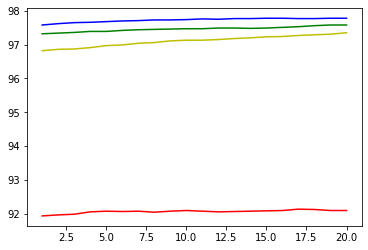

In [0]:
import matplotlib.pyplot as matplot
BS = 50
LR = 0.005
NB_EPOCH = 20
no_hidden = main_training(linear_classifier, linear_classifier_forward_and_backward, train_x, train_y, dev_x, dev_y, BS, LR, NB_EPOCH)
one_hidden = main_training(mlp_single_hidden, mlp_single_hidden_forward_and_backward, train_x, train_y, dev_x, dev_y, BS, LR, NB_EPOCH)
two_hidden = main_training(mlp_two_hidden, mlp_two_hidden_forward_and_backward, train_x, train_y, dev_x, dev_y, BS, LR, NB_EPOCH)
BS = 100
LR = 0.01
NB_EPOCH = 20
two_hidden_best = main_training(mlp_two_hidden, mlp_two_hidden_forward_and_backward, train_x, train_y, dev_x, dev_y, BS, LR, NB_EPOCH)
matplot.plot([i+1 for i in range(20)], no_hidden, "r")
matplot.plot([i+1 for i in range(20)], one_hidden, "y")
matplot.plot([i+1 for i in range(20)], two_hidden, "g")
matplot.plot([i+1 for i in range(20)], two_hidden_best, "b")
## The red line is for no hidden layer
## The yellow line is for single hidden layer
## The green line is for two hidden layers

  5%|| 1/20 [00:09<02:52,  9.09s/it]

epoch 0 train loss = 0.006 dev accuracy = 97.58%


 10%|| 2/20 [00:18<02:47,  9.30s/it]

epoch 1 train loss = 0.006 dev accuracy = 97.58%


 15%|| 3/20 [00:28<02:38,  9.30s/it]

epoch 2 train loss = 0.006 dev accuracy = 97.60%


 20%|| 4/20 [00:37<02:28,  9.28s/it]

epoch 3 train loss = 0.006 dev accuracy = 97.61%


 25%|| 5/20 [00:46<02:17,  9.17s/it]

epoch 4 train loss = 0.006 dev accuracy = 97.61%


 30%|| 6/20 [00:55<02:08,  9.19s/it]

epoch 5 train loss = 0.006 dev accuracy = 97.61%


 35%|| 7/20 [01:04<01:58,  9.15s/it]

epoch 6 train loss = 0.005 dev accuracy = 97.61%


 40%|| 8/20 [01:14<01:50,  9.22s/it]

epoch 7 train loss = 0.005 dev accuracy = 97.61%


 45%|| 9/20 [01:23<01:41,  9.25s/it]

epoch 8 train loss = 0.005 dev accuracy = 97.62%


 50%|| 10/20 [01:32<01:32,  9.30s/it]

epoch 9 train loss = 0.005 dev accuracy = 97.61%


 55%|| 11/20 [01:42<01:23,  9.30s/it]

epoch 10 train loss = 0.005 dev accuracy = 97.62%


 60%|| 12/20 [01:51<01:14,  9.35s/it]

epoch 11 train loss = 0.005 dev accuracy = 97.63%


 65%|| 13/20 [02:00<01:04,  9.28s/it]

epoch 12 train loss = 0.005 dev accuracy = 97.61%


 70%|| 14/20 [02:09<00:55,  9.29s/it]

epoch 13 train loss = 0.005 dev accuracy = 97.62%


 75%|| 15/20 [02:19<00:46,  9.37s/it]

epoch 14 train loss = 0.004 dev accuracy = 97.62%


 80%|| 16/20 [02:28<00:37,  9.32s/it]

epoch 15 train loss = 0.004 dev accuracy = 97.62%


 85%|| 17/20 [02:37<00:27,  9.24s/it]

epoch 16 train loss = 0.004 dev accuracy = 97.63%


 90%|| 18/20 [02:46<00:18,  9.17s/it]

epoch 17 train loss = 0.004 dev accuracy = 97.63%


 95%|| 19/20 [02:55<00:09,  9.15s/it]

epoch 18 train loss = 0.004 dev accuracy = 97.62%


100%|| 20/20 [03:04<00:00,  9.12s/it]

epoch 19 train loss = 0.004 dev accuracy = 97.62%
best dev accuracy = 97.63%


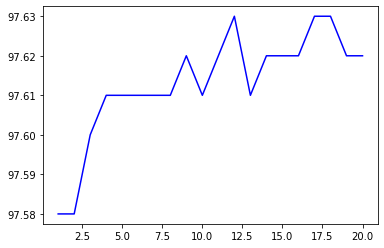

In [0]:
# possible_BS = [50, 100, 200, 300]
# possible_LR = [0.001, 0.005, 0.01, 0.2]
# possible_NB_EPOCH = [5, 10, 15, 20, 25, 30]
# best_accuracy = []
# best_setting = []
# for BS in possible_BS:
#     for LR in possible_LR:
#         for NB_EPOCH in possible_NB_EPOCH:
#             two_hidden = main_training(mlp_two_hidden, mlp_two_hidden_forward_and_backward, train_x, train_y, dev_x, dev_y, BS, LR, NB_EPOCH)
#             if best_accuracy == [] or best_accuracy[-1] < two_hidden[-1]:
#                 best_accuracy = two_hidden
#                 best_setting = [BS, LR, NB_EPOCH]
# matplot.plot([i+1 for i in range(len(best_accuracy))], best_accuracy, "b")
# print(best_setting)
BS = 100
LR = 0.01
NB_EPOCH = 20
two_hidden_best = main_training(mlp_two_hidden, mlp_two_hidden_forward_and_backward, train_x, train_y, test_x, test_y, BS, LR, NB_EPOCH)
matplot.plot([i+1 for i in range(len(two_hidden_best))], two_hidden_best, "b")